In [1]:
#!/usr/bin/env python3
import os
import cv2
import torch
import numpy as np
import matplotlib
# matplotlib.use("TkAgg")
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.ndimage import zoom

from utils import *
from config import *
from dataset import CarlaDataset  
from rcilv3d import RCILv3D

/home/pavlos/venv/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [65]:
CARLA_BASE_DIR = "/media/pavlos/HDD/Datasets/TeslaPilot/carla"
GAN_BASE_DIR = "/media/pavlos/HDD/Datasets/TeslaPilot/carla-cityscapes"
# TOWNS = TRAIN_TOWN_LIST + EVAL_TOWN_LIST
# TOWNS = ["Town01", "Town02", "Town03", "Town04", "Town05", "Town06", "Town07"]
TOWNS = ["Town06"]

In [66]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
print("[+] Using device:", device)

[+] Using device: cuda


In [67]:
carla_dataset = CarlaDataset(
  base_dir=CARLA_BASE_DIR,
  townslist=TOWNS,
  image_size=IMAGE_SIZE,
  use_imagenet_norm=USE_IMAGENET_NORM,
  sequence_size=SEQUENCE_SIZE,
  inference=True
)

[CarlaDataset] Loading Town06: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


In [68]:
gan_dataset = CarlaDataset(
  base_dir=GAN_BASE_DIR,
  townslist=TOWNS,
  image_size=IMAGE_SIZE,
  use_imagenet_norm=USE_IMAGENET_NORM,
  sequence_size=SEQUENCE_SIZE,
  inference=True
)

[CarlaDataset] Loading Town06: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


In [76]:
idx = 600

# TOWN_LEN = 10
# EPISODE_LEN = 1000
# town = 4
# episode = 8 
# offset = 0
# idx = town * TOWN_LEN + episode * EPISODE_LEN + offset

print(f"{idx}/{len(gan_dataset)}")
carla_sample = carla_dataset[idx]
gan_sample = gan_dataset[idx]

600/987


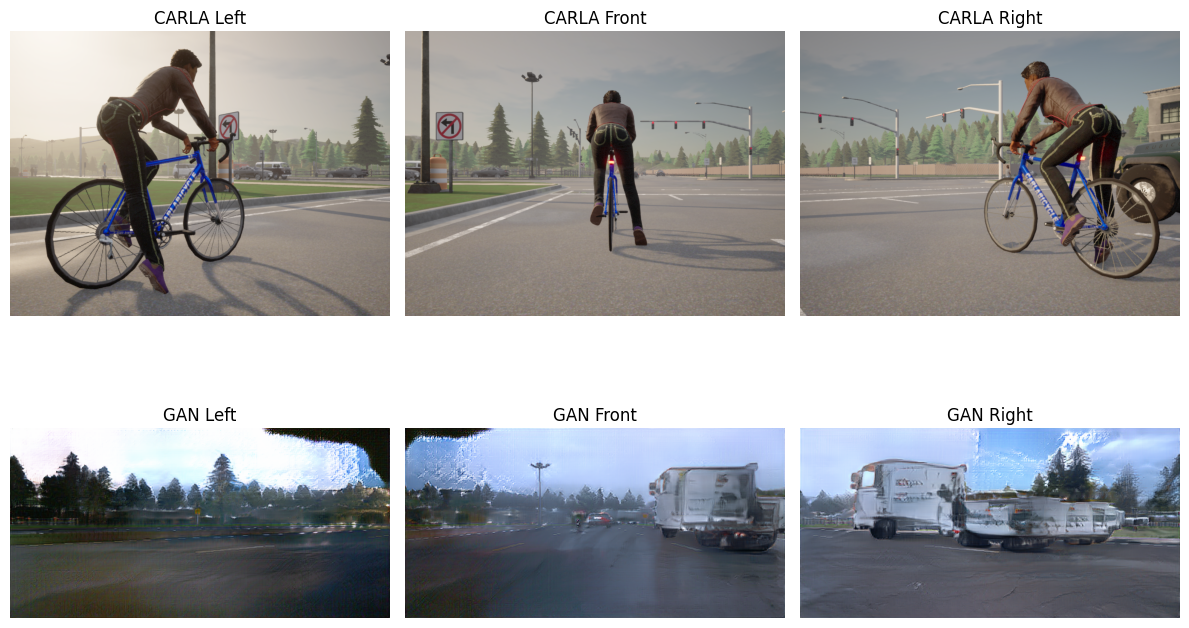

In [77]:
import matplotlib.pyplot as plt

t = 7

# CARLA (top row)
carla_left  = carla_sample[0]["rgb_left_disp"][t]
carla_front = carla_sample[0]["rgb_front_disp"][t]
carla_right = carla_sample[0]["rgb_right_disp"][t]

# GAN (bottom row)
gan_left  = gan_sample[0]["rgb_left_disp"][t]
gan_front = gan_sample[0]["rgb_front_disp"][t]
gan_right = gan_sample[0]["rgb_right_disp"][t]

fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# ---- Top row: CARLA ----
axes[0, 0].imshow(carla_left)
axes[0, 0].set_title("CARLA Left")
axes[0, 0].axis("off")

axes[0, 1].imshow(carla_front)
axes[0, 1].set_title("CARLA Front")
axes[0, 1].axis("off")

axes[0, 2].imshow(carla_right)
axes[0, 2].set_title("CARLA Right")
axes[0, 2].axis("off")

# ---- Bottom row: GAN ----
axes[1, 0].imshow(gan_left)
axes[1, 0].set_title("GAN Left")
axes[1, 0].axis("off")

axes[1, 1].imshow(gan_front)
axes[1, 1].set_title("GAN Front")
axes[1, 1].axis("off")

axes[1, 2].imshow(gan_right)
axes[1, 2].set_title("GAN Right")
axes[1, 2].axis("off")

plt.tight_layout()
plt.show()

In [127]:
from rcilv3d import RCILv3D, CILv3DConfig

CARLA_MODEL_PATH = "./checkpoints/RCILv3D/CILv3D_lookahead_5_best.pt"
cfg = CILv3DConfig()
cfg.freeze_backbone = False

carla_model = RCILv3D(device=device)
checkpoint = torch.load(CARLA_MODEL_PATH, weights_only=False, map_location=device)
carla_model.load_state_dict(checkpoint["model"])
carla_model.to(device)
carla_model.eval()
print(f"[+] CARLA Model {CARLA_MODEL_PATH} loaded successfully")

[*] RCILv3D configuration:
  sequence_size: 8
  state_size: 7
  command_size: 6
  filters_1d: 32
  embedding_size: 512
  transformer_heads: 8
  transformer_layers: 6
  freeze_backbone: True
  transformer_dropout: 0.4
  linear_dropout: 0.4
  use_revin: False
  uniformer_version: UniformerVersion.BASE



/home/pavlos/venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


KeyError: 'model'

In [ ]:
from rcilv3d import RCILv3D, CILv3DConfig

cfg = CILv3DConfig()
cfg.freeze_backbone = False
GAN_MODEL_PATH = "./checkpoints/sim2real_artifacts_val/CILv3D_artifacts_val_best.pt"

gan_model = RCILv3D(cfg=cfg, device=device)
checkpoint = torch.load(GAN_MODEL_PATH, weights_only=False, map_location=device)
gan_model.load_state_dict(checkpoint["model"])
gan_model.to(device)
gan_model.eval()
print(f"[+] CARLA Model {GAN_MODEL_PATH} loaded successfully")


[*] RCILv3D configuration:
  sequence_size: 8
  state_size: 7
  command_size: 6
  filters_1d: 32
  embedding_size: 512
  transformer_heads: 8
  transformer_layers: 6
  freeze_backbone: False
  transformer_dropout: 0.4
  linear_dropout: 0.4
  use_revin: False
  uniformer_version: UniformerVersion.BASE



/home/pavlos/venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


[+] CARLA Model ./checkpoints/sim2real_artifacts_val/CILv3D_artifacts_val_best.pt loaded successfully


In [ ]:
LEFT = gan_sample[0]["rgb_left"].unsqueeze(0).to(device)
FRONT = gan_sample[0]["rgb_front"].unsqueeze(0).to(device)
RIGHT = gan_sample[0]["rgb_right"].unsqueeze(0).to(device)
STATES = gan_sample[0]["states"].unsqueeze(0).to(device)
CMD = gan_sample[0]["commands"].unsqueeze(0).to(device)
Y = gan_sample[1].to(device)

out, layerouts = gan_model(LEFT, FRONT, RIGHT, STATES, CMD)
layerout_left, layerout_front, layerout_right = layerouts
layerout_left.retain_grad()
layerout_front.retain_grad()
layerout_right.retain_grad()

# Steering (action 0), first future timestep
score = out[:, 0, 0].sum()

gan_model.zero_grad()
score.backward()


In [128]:
import numpy as np
import cv2
import torch
from scipy.ndimage import zoom

def gradcam_video(RGB_vid, layerout, use_imagenet_norm=True, alpha=0.3):
    """
    RGB_vid:  (1, 3, T, H, W)
    layerout: (1, C, T, H, W)
    """
    grads = layerout.grad
    feats = layerout.detach()

    # Compute weights and CAM
    weights = grads.mean(dim=(3, 4), keepdim=True)
    cam = (weights * feats).sum(dim=1)
    cam = torch.relu(cam)[0]  # (T, H, W)
    cam = cam.cpu().numpy()

    # Resize CAM to match image
    T, H, W = cam.shape
    cam = zoom(cam, (1, RGB_vid.shape[3]/H, RGB_vid.shape[4]/W))

    # Normalize CAM to [0,1]
    cam -= cam.min()
    cam /= cam.max() + 1e-8

    heatmaps = []
    for t in range(cam.shape[0]):
        # Colorize
        heat = cv2.applyColorMap(np.uint8(255 * cam[t]), cv2.COLORMAP_JET)  # BGR
        heat = cv2.cvtColor(heat, cv2.COLOR_BGR2RGB) / 255.0               # convert to RGB, [0,1]

        # Denormalize input frame
        img = RGB_vid[0, :, t]
        if use_imagenet_norm:
            mean = torch.tensor([0.485, 0.456, 0.406], device=img.device).view(3,1,1)
            std  = torch.tensor([0.229, 0.224, 0.225], device=img.device).view(3,1,1)
            rgb = (img * std + mean).permute(1,2,0).cpu().numpy()
        else:
            rgb = img.permute(1,2,0).cpu().numpy()

        rgb = np.clip(rgb, 0, 1)

        # Blend: use low alpha for heatmap to avoid over-saturation
        overlay = (1 - alpha) * rgb + alpha * heat
        overlay = np.clip(overlay, 0, 1)
        heatmaps.append(overlay)

    return heatmaps

In [131]:
from PIL import Image
import torch
from torchvision import transforms

gan_left  = gan_sample[0]["rgb_left_disp"]   # (8, 256, 512, 3)
gan_front = gan_sample[0]["rgb_front_disp"]
gan_right = gan_sample[0]["rgb_right_disp"]

image_size = (224, 224)
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor()
])

def process_video(frames):
    # frames: (T, H, W, 3)
    tensors = []
    for t in range(frames.shape[0]):
        pil_img = Image.fromarray(frames[t].astype('uint8'))
        tensor = transform(pil_img)  # (3, 224, 224)
        tensors.append(tensor)
    # Stack along frame dimension -> (3, T, H, W)
    video_tensor = torch.stack(tensors, dim=1)  # (3, 8, 224, 224)
    # Add batch dimension -> (1, 3, 8, 224, 224)
    return video_tensor.unsqueeze(0)

gan_left_tensor  = process_video(gan_left)
gan_front_tensor = process_video(gan_front)
gan_right_tensor = process_video(gan_right)

alpha = 0.2

left_cams  = gradcam_video(gan_left_tensor,  layerout_left, alpha=alpha)
front_cams = gradcam_video(gan_front_tensor, layerout_front, alpha=alpha)
right_cams = gradcam_video(gan_right_tensor, layerout_right, alpha=alpha)

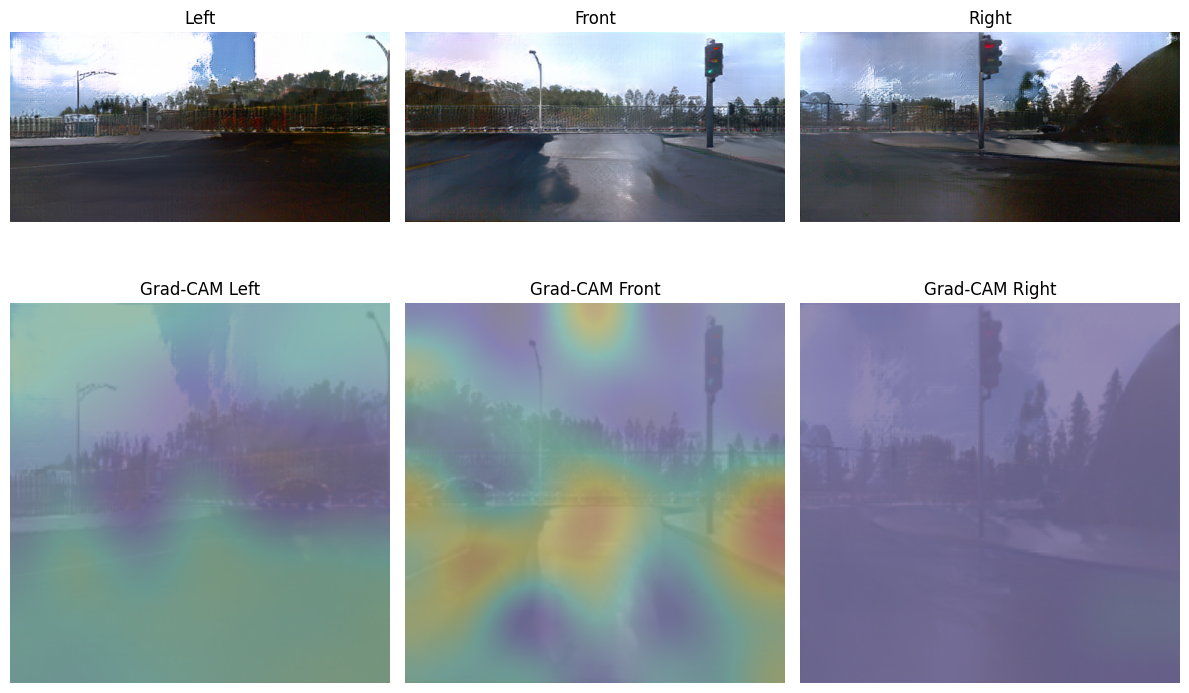

In [132]:
import matplotlib.pyplot as plt

t = 7
t_cam = min(t, len(left_cams) - 1)

fig, axes = plt.subplots(2, 3, figsize=(12, 8))

gan_left  = gan_sample[0]["rgb_left_disp"][t]
gan_front = gan_sample[0]["rgb_front_disp"][t]
gan_right = gan_sample[0]["rgb_right_disp"][t]

# Raw (denormalized)
axes[0,0].imshow(gan_left)
axes[0,0].set_title("Left")
axes[0,0].axis("off")

axes[0,1].imshow(gan_front)
axes[0,1].set_title("Front")
axes[0,1].axis("off")

axes[0,2].imshow(gan_right)
axes[0,2].set_title("Right")
axes[0,2].axis("off")

# Grad-CAM
axes[1,0].imshow(left_cams[t_cam])
axes[1,0].set_title("Grad-CAM Left")
axes[1,0].axis("off")

axes[1,1].imshow(front_cams[t_cam])
axes[1,1].set_title("Grad-CAM Front")
axes[1,1].axis("off")

axes[1,2].imshow(right_cams[t_cam])
axes[1,2].set_title("Grad-CAM Right")
axes[1,2].axis("off")

plt.tight_layout()
plt.show()

